In [82]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [83]:
# ==========================================
#              USER CONFIGURATION
# ==========================================

# 1. File Paths & Selection
FOLDER_PATH = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs"

# Filter: Only load files containing this string (e.g., "NR" or "WR")
FILE_FILTER = "NR" 

# List of specific filenames to use as the TEST set. 
# These will be excluded from training/validation automatically.
TEST_FILES = [
    "BIA24-5_NR_merged_with_gear.csv",
    "BIA24-22_NR_merged_with_gear.csv",
    "BIA24-5_WR_merged_with_gear.csv",
    "BIA24-22_WR_merged_with_gear.csv",
]

# 2. Input Features
INPUT_COLS = [
    'speed_kmph', 'power_w', 'frequency_ppm', 
    'thrust_left_ms', 'thrust_right_ms', 
    'impulse_left_ns', 'impulse_right_ns', 
    'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 
    'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts'
]

# 3. Output Label
LABEL_COL = "Gear"

# 4. Data Processing
SEQ_LEN = 5       # Frames
STEP = 1           # Stride
TRANSITION_WINDOW = 2 # +/- frames around a gear change to consider unstable

# 5. Model Architecture
HIDDEN_DIM = 32
NUM_LAYERS = 4
DROPOUT = 0.2

# 6. Training Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.00005
EPOCHS = 150

In [84]:
# ==========================================
#              HELPER FUNCTIONS
# ==========================================

def clean_gear_label(gear):
    """Normalize labels like '2.0' to '2'."""
    s = str(gear).strip()
    if '2.0' in s:
        return '2.0'
    return s

def mark_stable_regions(df, label_col='GearInt', window_size=25):
    """
    Mark unstable frames around gear transitions.
    This version correctly handles index 0 and does not over-mark.
    """
    gear_changes = df[label_col].ne(df[label_col].shift(1)).fillna(False)

    df = df.copy()
    df['StableFlag'] = True

    change_idxs = gear_changes[gear_changes].index.tolist()

    for idx in change_idxs:
        # only mark AFTER a change, not before
        start = idx
        end = min(len(df), idx + window_size)
        df.loc[start:end, 'StableFlag'] = False

    return df


In [85]:
# 1. Get list of files based on filter
all_csvs = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv')]

if FILE_FILTER:
    csv_files = [f for f in all_csvs if FILE_FILTER in f]
    print(f"Filter '{FILE_FILTER}' applied. Found {len(csv_files)} files.")
else:
    csv_files = all_csvs
    print(f"No filter applied. Found {len(csv_files)} files.")

# 2. Load Dataframes
dataframes = {}
for file in csv_files:
    full_path = os.path.join(FOLDER_PATH, file)
    df = pd.read_csv(full_path)
    
    if LABEL_COL in df.columns:
        # A. Clean labels
        df[LABEL_COL] = df[LABEL_COL].apply(clean_gear_label)
        
        # B. Mark stable regions (We do this for ALL files so the column exists)
        # We don't delete rows here anymore. We just mark them.
        df = mark_stable_regions(df, LABEL_COL, window_size=TRANSITION_WINDOW)

    dataframes[file] = df

# 3. Validation
valid_test_files = [tf for tf in TEST_FILES if tf in dataframes]
if len(valid_test_files) != len(TEST_FILES):
    print(f"WARNING: Some test files were not found. Using: {valid_test_files}")
TEST_FILES = valid_test_files

print("Data loading complete.")

Filter 'NR' applied. Found 12 files.
Data loading complete.


In [86]:
# 1. Identify keys available for training
train_pool_keys = sorted([k for k in dataframes.keys() if k not in TEST_FILES])

# 2. Split files for Train/Val
train_keys, val_keys = train_test_split(train_pool_keys, test_size=0.2, random_state=42)

print(f"Train files: {len(train_keys)}")
print(f"Val files:   {len(val_keys)}")
print(f"Test files:  {len(TEST_FILES)}")

# 3. Concatenate for Scaler/Encoder fitting
train_df = pd.concat([dataframes[k] for k in train_keys], ignore_index=True)
val_df = pd.concat([dataframes[k] for k in val_keys], ignore_index=True)

test_dfs_list = [dataframes[k] for k in TEST_FILES]
if test_dfs_list:
    test_df = pd.concat(test_dfs_list, ignore_index=True)
else:
    raise ValueError("No valid test files found!")

# Drop NaNs
train_df = train_df.dropna(subset=INPUT_COLS + [LABEL_COL])
val_df = val_df.dropna(subset=INPUT_COLS + [LABEL_COL])
test_df = test_df.dropna(subset=INPUT_COLS + [LABEL_COL])

# 4. Fit Label Encoder
all_labels = pd.concat([train_df[LABEL_COL], val_df[LABEL_COL], test_df[LABEL_COL]]).unique()
encoder = LabelEncoder()
encoder.fit(all_labels)
print(f"Classes found: {encoder.classes_}")

# 5. Fit Scaler (TRAIN ONLY)
scaler = StandardScaler()
scaler.fit(train_df[INPUT_COLS])
print("Scaler fitted on training data.")

Train files: 8
Val files:   2
Test files:  2


Classes found: ['0.0' '2.0' '3.0' '4.0']
Scaler fitted on training data.


In [87]:
def create_sequences(df, seq_len, step, is_train_mode=True):
    X_vals = df[INPUT_COLS].values
    y_vals = encoder.transform(df[LABEL_COL].values)
    
    # Check for stability mask
    if 'is_stable' in df.columns:
        stability_mask = df['is_stable'].values
    else:
        # Fallback if column missing (shouldn't happen)
        stability_mask = np.ones(len(df), dtype=bool)

    # Scale features
    X_vals = scaler.transform(X_vals)
    
    X_seqs = []
    y_seqs = []
    
    num_samples = len(df)
    
    for start_idx in range(0, num_samples - seq_len + 1, step):
        end_idx = start_idx + seq_len
        
        # --- STABILITY CHECK ---
        if is_train_mode:
            # If ANY frame in this window is unstable, SKIP IT.
            # This ensures we don't train on "impossible physics".
            window_stability = stability_mask[start_idx:end_idx]
            if not np.all(window_stability):
                continue 
        
        seq_x = X_vals[start_idx:end_idx]
        # Label is the state at the end of the sequence
        label_y = y_vals[end_idx - 1]
        
        X_seqs.append(seq_x)
        y_seqs.append(label_y)
        
    return np.array(X_seqs, dtype=np.float32), np.array(y_seqs, dtype=np.int64)

def prepare_dataset(keys, df_source, is_train_mode):
    # Case A: Handling Test Data (Single DataFrame)
    if isinstance(df_source, pd.DataFrame):
        return create_sequences(df_source, SEQ_LEN, STEP, is_train_mode=is_train_mode)
    
    # Case B: Handling Train/Val Data (List of keys)
    X_all, y_all = [], []
    for k in keys:
        df = dataframes[k].dropna(subset=INPUT_COLS + [LABEL_COL])
        X, y = create_sequences(df, SEQ_LEN, STEP, is_train_mode=is_train_mode)
        
        if len(X) > 0:
            X_all.append(X)
            y_all.append(y)
            
    if len(X_all) == 0:
        return np.array([]), np.array([])
        
    return np.concatenate(X_all), np.concatenate(y_all)

print("Building sequences...")

# TRAIN: Strict filtering (Clean data only)
X_train, y_train = prepare_dataset(train_keys, dataframes, is_train_mode=True)

# VAL: Strict filtering (Clean validation)
X_val, y_val = prepare_dataset(val_keys, dataframes, is_train_mode=True)

# TEST: NO FILTERING (Real-world evaluation with messy transitions)
X_test, y_test = prepare_dataset(None, test_df, is_train_mode=False) 

print(f"Train shape: {X_train.shape} (Cleaned)")
print(f"Val shape:   {X_val.shape} (Cleaned)")
print(f"Test shape:  {X_test.shape} (Raw/Dirty)")

# Create DataLoaders
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=BATCH_SIZE, shuffle=False)

Building sequences...
Train shape: (9062, 5, 14) (Cleaned)
Val shape:   (2169, 5, 14) (Cleaned)
Test shape:  (2415, 5, 14) (Raw/Dirty)


/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

Starting training...
Epoch [10/150] Train Loss: 0.7203 | Val Loss: 0.6975 | Val Acc: 74.23%
Epoch [20/150] Train Loss: 0.5994 | Val Loss: 0.6289 | Val Acc: 73.03%
Epoch [30/150] Train Loss: 0.5653 | Val Loss: 0.6079 | Val Acc: 73.49%
Epoch [40/150] Train Loss: 0.5488 | Val Loss: 0.6058 | Val Acc: 74.23%
Epoch [50/150] Train Loss: 0.5299 | Val Loss: 0.5995 | Val Acc: 74.41%
Epoch [60/150] Train Loss: 0.5212 | Val Loss: 0.5921 | Val Acc: 74.32%
Epoch [70/150] Train Loss: 0.5125 | Val Loss: 0.5761 | Val Acc: 75.10%
Epoch [80/150] Train Loss: 0.5029 | Val Loss: 0.5424 | Val Acc: 76.53%
Epoch [90/150] Train Loss: 0.4921 | Val Loss: 0.5200 | Val Acc: 77.87%
Epoch [100/150] Train Loss: 0.4813 | Val Loss: 0.4971 | Val Acc: 78.98%
Epoch [110/150] Train Loss: 0.4804 | Val Loss: 0.4976 | Val Acc: 79.02%
Epoch [120/150] Train Loss: 0.4728 | Val Loss: 0.4920 | Val Acc: 79.44%
Epoch [130/150] Train Loss: 0.4640 | Val Loss: 0.4899 | Val Acc: 79.71%
Epoch [140/150] Train Loss: 0.4569 | Val Loss: 0.486

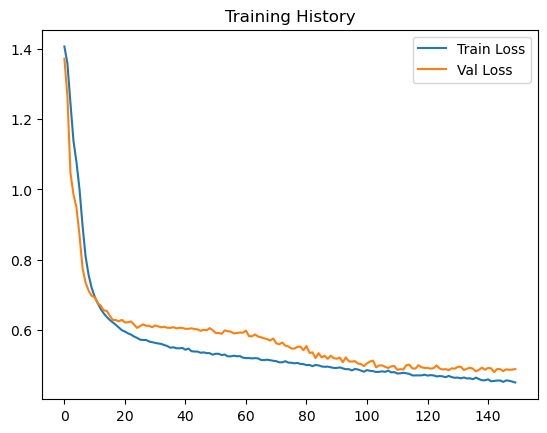

In [88]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        
        # Take only the last time step
        last_step = lstm_out[:, -1, :]
        
        out = self.fc(last_step)
        return out

model = SimpleLSTM(
    input_dim=len(INPUT_COLS),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=len(encoder.classes_),
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training History")
plt.legend()
plt.show()


--- Test Set Classification Report (Raw Data) ---
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.83       391
         2.0       0.94      0.89      0.92       363
         3.0       0.91      0.93      0.92      1430
         4.0       0.56      0.45      0.50       231

    accuracy                           0.87      2415
   macro avg       0.80      0.78      0.79      2415
weighted avg       0.86      0.87      0.86      2415



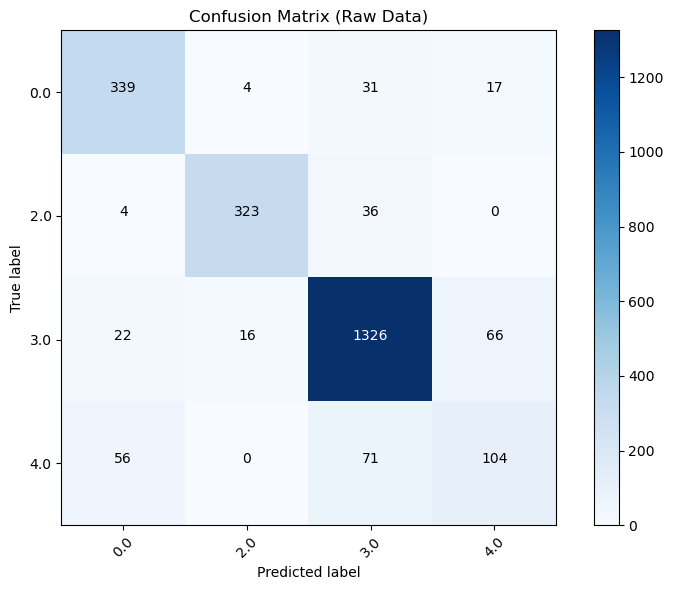

In [89]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation Metrics
print("\n--- Test Set Classification Report (Raw Data) ---")
print(classification_report(all_labels, all_preds, target_names=encoder.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Raw Data)')
plt.colorbar()

tick_marks = np.arange(len(encoder.classes_))
plt.xticks(tick_marks, encoder.classes_, rotation=45)
plt.yticks(tick_marks, encoder.classes_)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

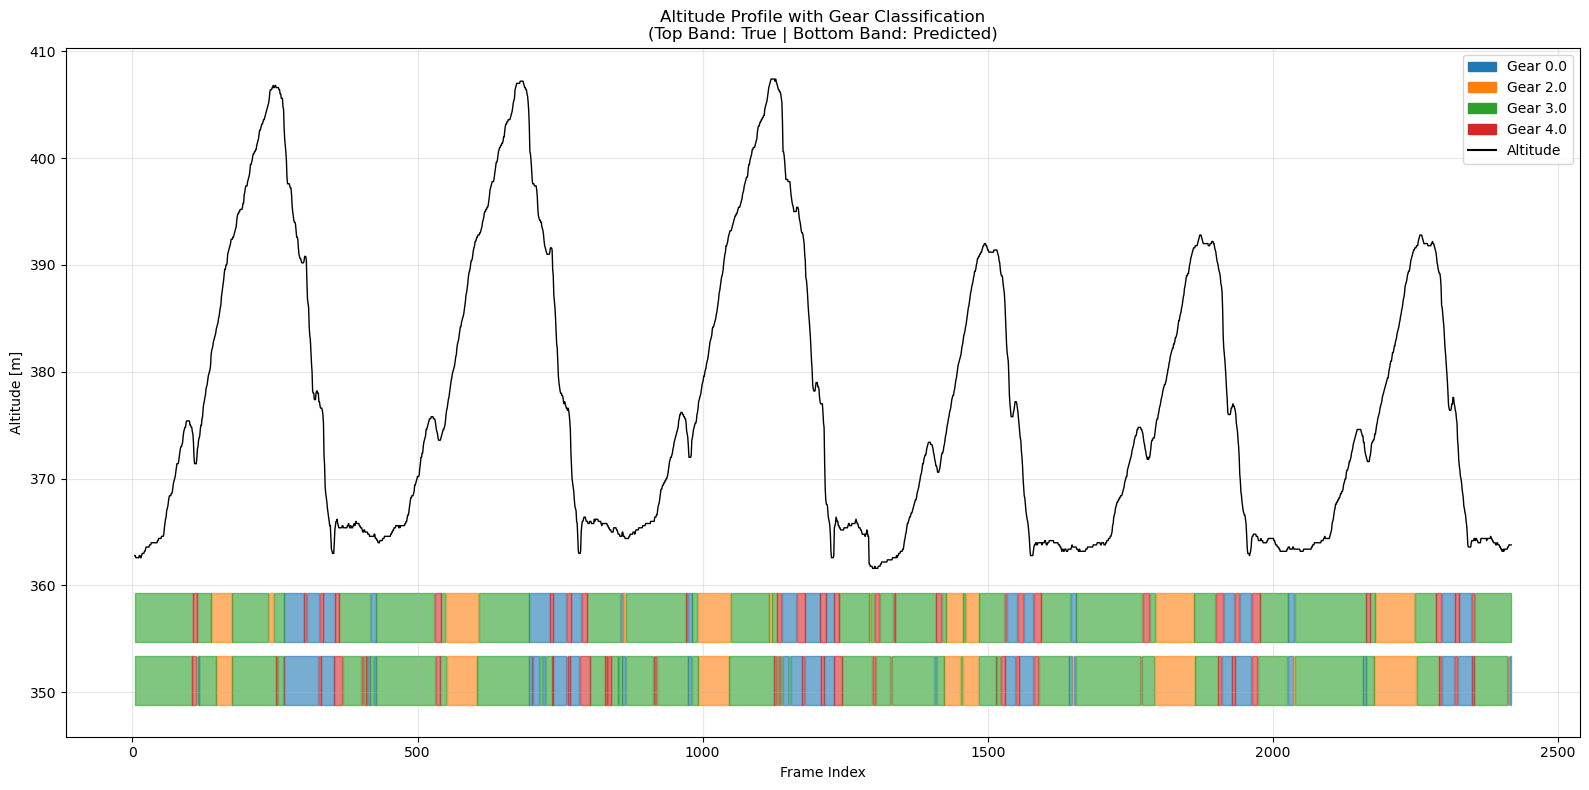

In [91]:
# ==========================================
# ALTITUDE vs TIME + TRUE/PRED GEAR BANDS
# ==========================================

import matplotlib.patches as mpatches

# 1. Align Data
# Since the model consumes a sequence (SEQ_LEN) to predict the label at the last step,
# we must align the Time/Altitude data by slicing off the first (SEQ_LEN - 1) frames.
# Note: We assume STEP=1. If STEP > 1, slicing would be test_df.iloc[SEQ_LEN-1::STEP]

cutoff = SEQ_LEN - 1

# Try to find a Time column, otherwise use index
time_col = 'Time' if 'Time' in test_df.columns else None
if time_col:
    t = test_df[time_col].values[cutoff:]
else:
    print("Warning: 'Time' column not found. Using DataFrame index.")
    t = test_df.index.values[cutoff:]

alt = test_df['ns1:AltitudeMeters'].values[cutoff:]

# Ensure lengths match exactly (handle potential off-by-one errors in edge cases)
min_len = min(len(t), len(all_preds), len(all_labels))
t = t[:min_len]
alt = alt[:min_len]
pred_int = np.array(all_preds)[:min_len]
true_int = np.array(all_labels)[:min_len]

# 2. Decode Labels (Integers -> Original Strings)
# We map integers back to original labels (e.g., 0 -> 'Gear 2') for the legend
pred_str = encoder.inverse_transform(pred_int)
true_str = encoder.inverse_transform(true_int)
unique_classes_str = encoder.classes_

# 3. Setup Colors
# Create a consistent color map for the classes
cmap = plt.get_cmap("tab10")
class_to_color = {cls_name: cmap(i) for i, cls_name in enumerate(unique_classes_str)}

# 4. Plotting
plt.figure(figsize=(16, 8))

# A. Plot Altitude
plt.plot(t, alt, color='black', linewidth=1, label="Altitude", zorder=10)

# Calculate dynamic y-positions for the bands based on altitude range
y_min, y_max = alt.min(), alt.max()
y_range = y_max - y_min

# Band positions (placed slightly below the minimum altitude)
true_band_top = y_min - (0.05 * y_range)
true_band_bot = y_min - (0.15 * y_range)
pred_band_top = y_min - (0.18 * y_range)
pred_band_bot = y_min - (0.28 * y_range)

# B. Plot TRUE Gear Band
# We iterate through unique classes to fill sections
for cls_name in unique_classes_str:
    mask = (true_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, true_band_bot, true_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid' # Important for discrete steps
        )

# C. Plot PREDICTED Gear Band
for cls_name in unique_classes_str:
    mask = (pred_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, pred_band_bot, pred_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid'
        )

# D. Formatting & Legend
plt.xlabel("Time" if time_col else "Frame Index")
plt.ylabel("Altitude [m]")
plt.title("Altitude Profile with Gear Classification\n(Top Band: True | Bottom Band: Predicted)")

# Create custom legend handles
handles = [mpatches.Patch(color=class_to_color[c], label=f"Gear {c}") for c in unique_classes_str]
handles.append(plt.Line2D([], [], color='black', label='Altitude'))

plt.legend(handles=handles, loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()